#Setup

In [1]:
!pip install -U tensorboard_plugin_profile tensorflow-addons
!pip install -q tensorflow-model-optimization

%load_ext tensorboard

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 41.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 39.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 3.0 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import os

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


#Data Preprocessing

In [3]:
class_map = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck"
}

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

def preprocess(x):
    x = x.astype('float32') / 255
    return x

x_train = preprocess(x_train)
x_test = preprocess(x_test)

subsample_ratio = 1.0
subsample_index = int(len(x_train) * subsample_ratio)
x_train = x_train[:subsample_index]
y_train = y_train[:subsample_index]

subsample_index = int(len(x_test) * subsample_ratio)
x_test = x_test[:subsample_index]
y_test = y_test[:subsample_index]


170498071/170498071 [==============================] - 13s 0us/step


In [4]:
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))

batch_size = 128

train_data = train_data.shuffle(16 * batch_size)

train_data = train_data.batch(batch_size)
test_data = test_data.batch(batch_size)

cifar10_means = np.array([np.mean(x_train[:, :, :, 0]), np.mean(x_train[:, :, :, 1]), np.mean(x_train[:, :, :, 2])])
cifar10_stds = np.array([np.std(x_train[:, :, :, 0]), np.std(x_train[:, :, :, 1]), np.std(x_train[:, :, :, 2])])

def random_shift(x, shift_amount):
    """ Randomly shifts images by up to HxW pixels = `shift_amount`. """
    h_pixels, w_pixels = shift_amount
    orig = tf.shape(x)
    paddings = tf.constant([[0, 0], [w_pixels, w_pixels], [h_pixels, h_pixels], [0, 0]])
    x = tf.pad(x, mode="SYMMETRIC", paddings=paddings)
    return tf.image.random_crop(x, size=orig)

def transform_data(xs, ys):

    xs = tf.image.random_flip_left_right(xs)
    xs = tfa.image.random_cutout(xs, mask_size=(12, 12))
    xs = random_shift(xs, (4, 4))

    return xs, ys

def normalise(xs, ys):

    xs = (xs - cifar10_means) / cifar10_stds
    return xs, ys

def undo_normalisation(x):
    return np.clip(x * cifar10_stds + cifar10_means, 0.0, 1.0)

# Augmentation and normalisation
train_data = train_data.map(transform_data).map(normalise)
test_data = test_data.map(normalise)

Train batch:
	bird


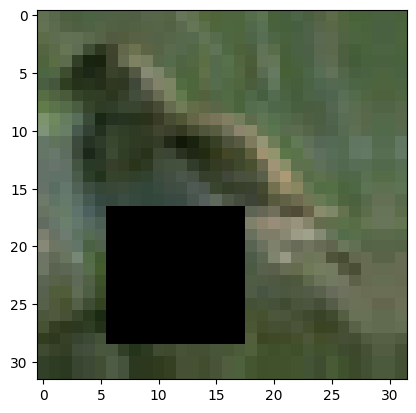

	horse


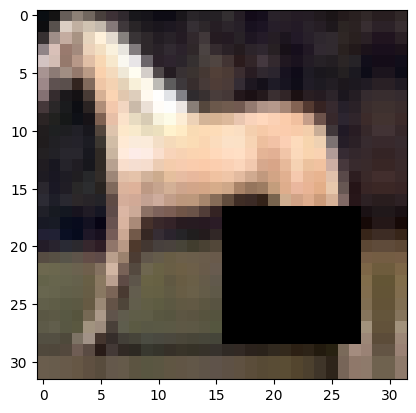

	horse


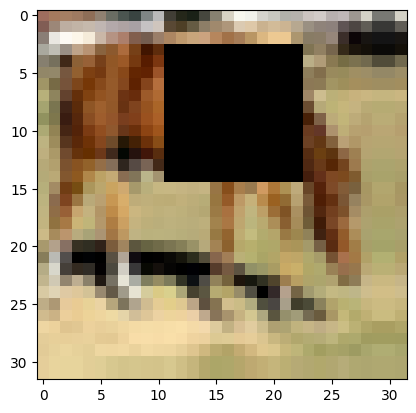

Test batch:
	cat


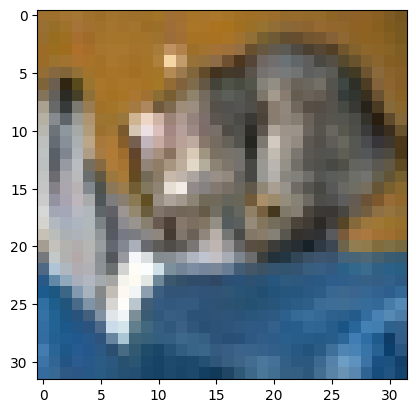

	ship


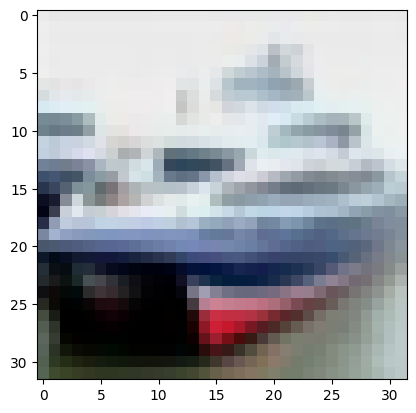

	ship


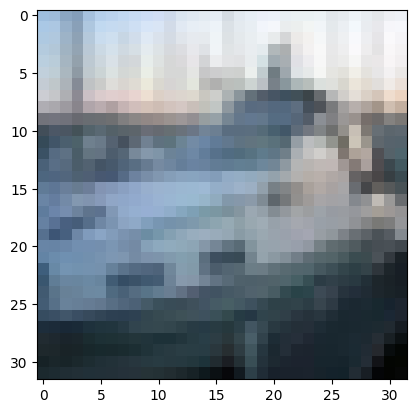

In [5]:
# Visualise data
import matplotlib.pyplot as plt
import numpy as np

train_batch, train_target = next(train_data.as_numpy_iterator())
test_batch, test_target = next(test_data.as_numpy_iterator())

print("Train batch:")
for i in range(3):
    print(f"\t{class_map[train_target[i][0]]}")
    plt.imshow(undo_normalisation(train_batch[i]))
    plt.show()

print("Test batch:")
for i in range(3):
    print(f"\t{class_map[test_target[i][0]]}")
    plt.imshow(undo_normalisation(test_batch[i]))
    plt.show()

#Initial CNN

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model

def conv_net(input_shape=(32, 32, 3), num_classes=10):

    i = layers.Input(shape=input_shape)
    x = i

    #alpha = 1.0
    x = layers.Conv2D(32, kernel_size=3, strides=(1, 1),
                      padding='same', use_bias=False, name='Conv1')(x)
    x = layers.BatchNormalization(name='bn_Conv1')(x)
    x = layers.ReLU(name='Conv1_relu')(x)

    x = layers.Conv2D(64, kernel_size=2, strides=(1, 1),
                      padding='same', use_bias=False, name='Conv2')(x)
    x = layers.BatchNormalization(name='bn_Conv2')(x)
    x = layers.ReLU(name='Conv2_relu')(x)

    x = layers.Conv2D(64, kernel_size=2, strides=(1, 1),
                      padding='same', use_bias=False, name='Conv3')(x)
    x = layers.BatchNormalization(name='bn_Conv3')(x)
    x = layers.ReLU(name='Conv3_relu')(x)

    x = layers.Conv2D(128, kernel_size=2, strides=(1, 1),
                      padding='same', use_bias=False, name='Conv4')(x)
    x = layers.BatchNormalization(name='bn_Conv4')(x)
    x = layers.ReLU(name='Conv4_relu')(x)

    x = layers.Conv2D(256, kernel_size=2, strides=(1, 1),
                      padding='same', use_bias=False, name='Conv5')(x)
    x = layers.BatchNormalization(name='bn_Conv5')(x)
    x = layers.ReLU(name='Conv5_relu')(x)

    x = layers.Conv2D(512, kernel_size=2, strides=(1, 1),
                      padding='same', use_bias=False, name='Conv6')(x)
    x = layers.BatchNormalization(name='bn_Conv6')(x)
    x = layers.ReLU(name='Conv6_relu')(x)

    x = layers.Conv2D(1024, kernel_size=1, use_bias=False, name='Conv_l', padding="valid")(x)
    x = layers.BatchNormalization(name='Conv_l_bn')(x)
    x = layers.ReLU(name='conv_l_relu')(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes, name='predictions')(x)

    return Model(i, x)


In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler, TensorBoard
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import SGD

tf.config.optimizer.set_jit(True)

train_data = train_data.prefetch(1)
test_data = test_data.prefetch(1)

model_conv_net = conv_net()
model_conv_net.compile(loss=SparseCategoricalCrossentropy(from_logits=True),
              optimizer=SGD(learning_rate=0.1, momentum=0.9, weight_decay=0.0, nesterov=False),
              metrics=['accuracy'])

def train_model(model):
    def lr_schedule(epoch):
        if 0 <= epoch < 35:
            return 0.1
        if 35 <= epoch < 65:
            return 0.01
        return 0.001

    model.fit(
        train_data, validation_data=test_data,
        epochs=90, # Set no. of epochs
        callbacks=[
            LearningRateScheduler(lr_schedule),
            TensorBoard(log_dir="./tb_logs", profile_batch='25, 35')  # Profile between the 25th and 35th forward pass
        ])

In [ ]:
train_model(model_conv_net)

Epoch 1/90
391/391 [==============================] - 31s 35ms/step - loss: 1.7816 - accuracy: 0.3330 - val_loss: 1.7538 - val_accuracy: 0.3844 - lr: 0.1000
Epoch 2/90
391/391 [==============================] - 19s 48ms/step - loss: 1.4297 - accuracy: 0.4805 - val_loss: 2.4477 - val_accuracy: 0.3420 - lr: 0.1000
Epoch 3/90
391/391 [==============================] - 9s 23ms/step - loss: 1.2742 - accuracy: 0.5388 - val_loss: 1.2788 - val_accuracy: 0.5636 - lr: 0.1000
Epoch 4/90
391/391 [==============================] - 9s 23ms/step - loss: 1.1734 - accuracy: 0.5771 - val_loss: 1.3672 - val_accuracy: 0.4945 - lr: 0.1000
Epoch 5/90
391/391 [==============================] - 9s 23ms/step - loss: 1.0829 - accuracy: 0.6117 - val_loss: 1.0255 - val_accuracy: 0.6387 - lr: 0.1000
Epoch 6/90
391/391 [==============================] - 9s 23ms/step - loss: 1.0187 - accuracy: 0.6363 - val_loss: 1.6128 - val_accuracy: 0.5470 - lr: 0.1000
Epoch 7/90
391/391 [==============================] - 9s 23ms/

#Baseline Model

In [6]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model

def mobilenet_v2_like(input_shape=(32, 32, 3), num_classes=10):
    def _inverted_res_block(i, filters, alpha, stride, expansion, block_id):
        prefix = 'block_{}_'.format(block_id)
        in_channels = i.shape[-1]
        x = i

        # Expand
        x = layers.Conv2D(expansion * in_channels, kernel_size=1, padding='valid',
                          use_bias=False, activation=None, name=prefix + 'expand')(x)
        x = layers.BatchNormalization(name=prefix + 'expand_BN')(x)
        x = layers.ReLU(name=prefix + 'expand_relu')(x)

        # Depthwise
        x = layers.DepthwiseConv2D(kernel_size=3, strides=stride, activation=None,
                                   use_bias=False, padding='same', name=prefix + 'depthwise')(x)
        x = layers.BatchNormalization(name=prefix + 'depthwise_BN')(x)
        x = layers.ReLU(name=prefix + 'depthwise_relu')(x)

        # Project
        pointwise_filters = int(filters * alpha)
        x = layers.Conv2D(pointwise_filters, kernel_size=1, padding='valid', use_bias=False,
                          activation=None, name=prefix + 'project')(x)
        x = layers.BatchNormalization(name=prefix + 'project_BN')(x)

        if stride == 1:
            if in_channels != pointwise_filters:
                i = layers.Conv2D(pointwise_filters, kernel_size=1, padding='valid', use_bias=False,
                                  activation=None, name=prefix + 'adjust')(i)
            x = layers.Add(name=prefix + 'add')([i, x])
        return x

    i = layers.Input(shape=input_shape)
    x = i

    alpha = 1.0
    x = layers.Conv2D(32, kernel_size=3, strides=(1, 1),
                      padding='same', use_bias=False, name='Conv1')(x)
    x = layers.BatchNormalization(name='bn_Conv1')(x)
    x = layers.ReLU(name='Conv1_relu')(x)

    x = _inverted_res_block(x, filters=16, alpha=alpha, stride=1, expansion=1, block_id=0)

    x = _inverted_res_block(x, filters=24, alpha=alpha, stride=1, expansion=6, block_id=1)
    x = _inverted_res_block(x, filters=24, alpha=alpha, stride=1, expansion=6, block_id=2)

    x = _inverted_res_block(x, filters=32, alpha=alpha, stride=2, expansion=6, block_id=3)
    x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1, expansion=6, block_id=4)
    x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1, expansion=6, block_id=5)

    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=2, expansion=6, block_id=6)
    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, expansion=6, block_id=7)
    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, expansion=6, block_id=8)
    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, expansion=6, block_id=9)

    x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1, expansion=6, block_id=10)
    x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1, expansion=6, block_id=11)
    x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1, expansion=6, block_id=12)

    x = _inverted_res_block(x, filters=160, alpha=alpha, stride=2, expansion=6, block_id=13)
    x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1, expansion=6, block_id=14)
    x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1, expansion=6, block_id=15)

    x = _inverted_res_block(x, filters=320, alpha=alpha, stride=1, expansion=6, block_id=16)

    x = layers.Conv2D(1280, kernel_size=1, use_bias=False, name='Conv_1', padding="valid")(x)
    x = layers.BatchNormalization(name='Conv_1_bn')(x)
    x = layers.ReLU(name='out_relu')(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes, name='predictions')(x)

    return Model(i, x)


In [7]:
from tensorflow.keras.callbacks import LearningRateScheduler, TensorBoard
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import SGD

tf.config.optimizer.set_jit(True)

train_data = train_data.prefetch(1)
test_data = test_data.prefetch(1)

model_mobilenet = mobilenet_v2_like()
model_mobilenet.compile(loss=SparseCategoricalCrossentropy(from_logits=True),
              optimizer=SGD(learning_rate=0.1, momentum=0.9, weight_decay=0.0, nesterov=False),
              metrics=['accuracy'])

def train_model(model):
    def lr_schedule(epoch):
        if 0 <= epoch < 35:
            return 0.1
        if 35 <= epoch < 65:
            return 0.01
        return 0.001

    model.fit(
        train_data, validation_data=test_data,
        epochs=60, # Set no. of epochs
        callbacks=[
            LearningRateScheduler(lr_schedule),
            TensorBoard(log_dir="./tb_logs", profile_batch='25, 35')  # Profile between the 25th and 35th forward pass
        ])

In [ ]:
train_model(model_mobilenet)

Epoch 1/60
391/391 [==============================] - 61s 63ms/step - loss: 1.8366 - accuracy: 0.3423 - val_loss: 1.6570 - val_accuracy: 0.4157 - lr: 0.1000
Epoch 2/60
391/391 [==============================] - 39s 99ms/step - loss: 1.3415 - accuracy: 0.5115 - val_loss: 1.5875 - val_accuracy: 0.4841 - lr: 0.1000
Epoch 3/60
391/391 [==============================] - 19s 48ms/step - loss: 1.1159 - accuracy: 0.5991 - val_loss: 1.0697 - val_accuracy: 0.6479 - lr: 0.1000
Epoch 4/60
391/391 [==============================] - 18s 47ms/step - loss: 0.9755 - accuracy: 0.6541 - val_loss: 0.9929 - val_accuracy: 0.6660 - lr: 0.1000
Epoch 5/60
391/391 [==============================] - 20s 50ms/step - loss: 0.8697 - accuracy: 0.6917 - val_loss: 0.8909 - val_accuracy: 0.7090 - lr: 0.1000
Epoch 6/60
391/391 [==============================] - 19s 48ms/step - loss: 0.7833 - accuracy: 0.7251 - val_loss: 0.7981 - val_accuracy: 0.7374 - lr: 0.1000
Epoch 7/60
391/391 [==============================] - 19s 

In [ ]:
tf.keras.models.save_model(model_mobilenet, "model_mobilenet.h5", include_optimizer=False)
hist_mobilenet = model_mobilenet.history.history

print(f"Total params: {model_mobilenet.count_params()}")
model_mobilenet.evaluate(test_data)

<ipython-input-9-f8dcb04fd084>:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_mobilenet, "model_mobilenet.h5", include_optimizer=False)


Total params: 2330186
79/79 [==============================] - 1s 13ms/step - loss: 0.2422 - accuracy: 0.9289


[0.24215303361415863, 0.9289000034332275]

In [8]:
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile
  import tempfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)

In [ ]:
print(f"Keras model (with DepthWiseConv) gzip size (bytes): {get_gzipped_model_size('model_mobilenet.h5')}")

Keras model (with DepthWiseConv) gzip size (bytes): 8678813


Text(0.5, 1.0, 'Accuracy vs. Epochs')

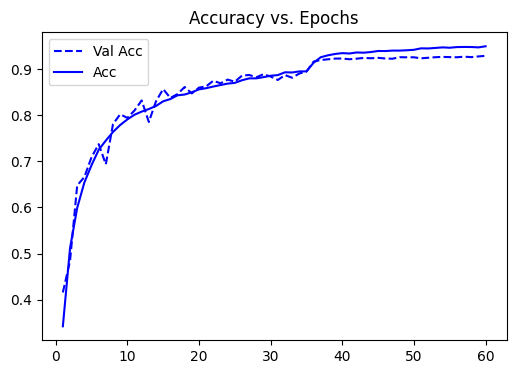

In [ ]:
import matplotlib.pyplot as plt

no_epochs = len(hist_mobilenet['accuracy'])

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
ax.plot(range(1, no_epochs + 1), hist_mobilenet['val_accuracy'], label='Val Acc', ls='--', color='blue')
ax.plot(range(1, no_epochs + 1), hist_mobilenet['accuracy'], label='Acc', ls='-', color='blue')
ax.legend()
ax.set_title("Accuracy vs. Epochs")

In [ ]:
import pandas as pd

df = pd.DataFrame(hist_mobilenet)
df.to_csv('hist_mobilenet.csv', index=False)

###Defining smaller architectures to serve as student models during knowledge distillation

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model

def small_mobilenet_v2_like(input_shape=(32, 32, 3), num_classes=10):
    def _inverted_res_block(i, filters, alpha, stride, expansion, block_id):
        prefix = 'block_{}_'.format(block_id)
        in_channels = i.shape[-1]
        x = i

        # Expand
        x = layers.Conv2D(expansion * in_channels, kernel_size=1, padding='valid',
                          use_bias=False, activation=None, name=prefix + 'expand')(x)
        x = layers.BatchNormalization(name=prefix + 'expand_BN')(x)
        x = layers.ReLU(name=prefix + 'expand_relu')(x)

        # Depthwise
        x = layers.DepthwiseConv2D(kernel_size=3, strides=stride, activation=None,
                                   use_bias=False, padding='same', name=prefix + 'depthwise')(x)
        x = layers.BatchNormalization(name=prefix + 'depthwise_BN')(x)
        x = layers.ReLU(name=prefix + 'depthwise_relu')(x)

        # Project
        pointwise_filters = int(filters * alpha)
        x = layers.Conv2D(pointwise_filters, kernel_size=1, padding='valid', use_bias=False,
                          activation=None, name=prefix + 'project')(x)
        x = layers.BatchNormalization(name=prefix + 'project_BN')(x)

        if stride == 1:
            if in_channels != pointwise_filters:
                i = layers.Conv2D(pointwise_filters, kernel_size=1, padding='valid', use_bias=False,
                                  activation=None, name=prefix + 'adjust')(i)
            x = layers.Add(name=prefix + 'add')([i, x])
        return x

    i = layers.Input(shape=input_shape)
    x = i

    alpha = 1.0
    x = layers.Conv2D(32, kernel_size=3, strides=(1, 1),
                      padding='same', use_bias=False, name='Conv1')(x)
    x = layers.BatchNormalization(name='bn_Conv1')(x)
    x = layers.ReLU(name='Conv1_relu')(x)

    x = _inverted_res_block(x, filters=16, alpha=alpha, stride=1, expansion=1, block_id=0)

    x = _inverted_res_block(x, filters=24, alpha=alpha, stride=1, expansion=6, block_id=1)
    x = _inverted_res_block(x, filters=24, alpha=alpha, stride=1, expansion=6, block_id=2)

    x = _inverted_res_block(x, filters=32, alpha=alpha, stride=2, expansion=6, block_id=3)
    x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1, expansion=6, block_id=4)
    x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1, expansion=6, block_id=5)

    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=2, expansion=6, block_id=6)
    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, expansion=6, block_id=7)
    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, expansion=6, block_id=9)

    x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1, expansion=6, block_id=10)

    x = _inverted_res_block(x, filters=160, alpha=alpha, stride=2, expansion=6, block_id=13)

    x = _inverted_res_block(x, filters=320, alpha=alpha, stride=1, expansion=6, block_id=16)

    x = layers.Conv2D(1280, kernel_size=1, use_bias=False, name='Conv_1', padding="valid")(x)
    x = layers.BatchNormalization(name='Conv_1_bn')(x)
    x = layers.ReLU(name='out_relu')(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes, name='predictions')(x)

    return Model(i, x)


In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler, TensorBoard
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import SGD

tf.config.optimizer.set_jit(True)

train_data = train_data.prefetch(1)
test_data = test_data.prefetch(1)

model = small_mobilenet_v2_like()
model.compile(loss=SparseCategoricalCrossentropy(from_logits=True),
              optimizer=SGD(learning_rate=0.1, momentum=0.9, weight_decay=0.0, nesterov=False),
              metrics=['accuracy'])

def train_model(model):
    def lr_schedule(epoch):
        if 0 <= epoch < 35:
            return 0.1
        if 35 <= epoch < 65:
            return 0.01
        return 0.001

    model.fit(
        train_data, validation_data=test_data,
        epochs=60, # Set no. of epochs
        callbacks=[
            LearningRateScheduler(lr_schedule),
            TensorBoard(log_dir="./tb_logs", profile_batch='25, 35')  # Profile between the 25th and 35th forward pass
        ])

train_model(model)

In [ ]:
# Small 2
from tensorflow.keras import layers
from tensorflow.keras.models import Model

def small2_mobilenet_v2_like(input_shape=(32, 32, 3), num_classes=10):
    def _inverted_res_block(i, filters, alpha, stride, expansion, block_id):
        prefix = 'block_{}_'.format(block_id)
        in_channels = i.shape[-1]
        x = i

        # Expand
        x = layers.Conv2D(expansion * in_channels, kernel_size=1, padding='valid',
                          use_bias=False, activation=None, name=prefix + 'expand')(x)
        x = layers.BatchNormalization(name=prefix + 'expand_BN')(x)
        x = layers.ReLU(name=prefix + 'expand_relu')(x)

        # Depthwise
        x = layers.DepthwiseConv2D(kernel_size=3, strides=stride, activation=None,
                                   use_bias=False, padding='same', name=prefix + 'depthwise')(x)
        x = layers.BatchNormalization(name=prefix + 'depthwise_BN')(x)
        x = layers.ReLU(name=prefix + 'depthwise_relu')(x)

        # Project
        pointwise_filters = int(filters * alpha)
        x = layers.Conv2D(pointwise_filters, kernel_size=1, padding='valid', use_bias=False,
                          activation=None, name=prefix + 'project')(x)
        x = layers.BatchNormalization(name=prefix + 'project_BN')(x)

        if stride == 1:
            if in_channels != pointwise_filters:
                i = layers.Conv2D(pointwise_filters, kernel_size=1, padding='valid', use_bias=False,
                                  activation=None, name=prefix + 'adjust')(i)
            x = layers.Add(name=prefix + 'add')([i, x])
        return x

    i = layers.Input(shape=input_shape)
    x = i

    alpha = 1.0
    x = layers.Conv2D(32, kernel_size=3, strides=(1, 1),
                      padding='same', use_bias=False, name='Conv1')(x)
    x = layers.BatchNormalization(name='bn_Conv1')(x)
    x = layers.ReLU(name='Conv1_relu')(x)

    x = _inverted_res_block(x, filters=16, alpha=alpha, stride=1, expansion=1, block_id=0)

    x = _inverted_res_block(x, filters=24, alpha=alpha, stride=1, expansion=6, block_id=1)

    x = _inverted_res_block(x, filters=32, alpha=alpha, stride=2, expansion=6, block_id=3)
    x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1, expansion=6, block_id=5)

    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=2, expansion=6, block_id=6)
    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, expansion=6, block_id=9)

    x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1, expansion=6, block_id=10)

    x = _inverted_res_block(x, filters=160, alpha=alpha, stride=2, expansion=6, block_id=13)

    x = _inverted_res_block(x, filters=320, alpha=alpha, stride=1, expansion=6, block_id=16)

    x = layers.Conv2D(1280, kernel_size=1, use_bias=False, name='Conv_1', padding="valid")(x)
    x = layers.BatchNormalization(name='Conv_1_bn')(x)
    x = layers.ReLU(name='out_relu')(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes, name='predictions')(x)

    return Model(i, x)


In [ ]:
#small 3
from tensorflow.keras import layers
from tensorflow.keras.models import Model

def small3_mobilenet_v2_like(input_shape=(32, 32, 3), num_classes=10):
    def _inverted_res_block(i, filters, alpha, stride, expansion, block_id):
        prefix = 'block_{}_'.format(block_id)
        in_channels = i.shape[-1]
        x = i

        # Expand
        x = layers.Conv2D(expansion * in_channels, kernel_size=1, padding='valid',
                          use_bias=False, activation=None, name=prefix + 'expand')(x)
        x = layers.BatchNormalization(name=prefix + 'expand_BN')(x)
        x = layers.ReLU(name=prefix + 'expand_relu')(x)

        # Depthwise
        x = layers.DepthwiseConv2D(kernel_size=3, strides=stride, activation=None,
                                   use_bias=False, padding='same', name=prefix + 'depthwise')(x)
        x = layers.BatchNormalization(name=prefix + 'depthwise_BN')(x)
        x = layers.ReLU(name=prefix + 'depthwise_relu')(x)

        # Project
        pointwise_filters = int(filters * alpha)
        x = layers.Conv2D(pointwise_filters, kernel_size=1, padding='valid', use_bias=False,
                          activation=None, name=prefix + 'project')(x)
        x = layers.BatchNormalization(name=prefix + 'project_BN')(x)

        if stride == 1:
            if in_channels != pointwise_filters:
                i = layers.Conv2D(pointwise_filters, kernel_size=1, padding='valid', use_bias=False,
                                  activation=None, name=prefix + 'adjust')(i)
            x = layers.Add(name=prefix + 'add')([i, x])
        return x

    i = layers.Input(shape=input_shape)
    x = i

    alpha = 1.0
    x = layers.Conv2D(32, kernel_size=3, strides=(1, 1),
                      padding='same', use_bias=False, name='Conv1')(x)
    x = layers.BatchNormalization(name='bn_Conv1')(x)
    x = layers.ReLU(name='Conv1_relu')(x)

    x = _inverted_res_block(x, filters=16, alpha=alpha, stride=1, expansion=1, block_id=0)

    x = _inverted_res_block(x, filters=32, alpha=alpha, stride=2, expansion=6, block_id=3)

    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=2, expansion=6, block_id=6)

    x = _inverted_res_block(x, filters=320, alpha=alpha, stride=1, expansion=6, block_id=16)

    x = layers.Conv2D(1280, kernel_size=1, use_bias=False, name='Conv_1', padding="valid")(x)
    x = layers.BatchNormalization(name='Conv_1_bn')(x)
    x = layers.ReLU(name='out_relu')(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes, name='predictions')(x)

    return Model(i, x)


In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler, TensorBoard
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import SGD

tf.config.optimizer.set_jit(True)

train_data = train_data.prefetch(1)
test_data = test_data.prefetch(1)

model = small3_mobilenet_v2_like()
model.compile(loss=SparseCategoricalCrossentropy(from_logits=True),
              optimizer=SGD(learning_rate=0.1, momentum=0.9, weight_decay=0.0, nesterov=False),
              metrics=['accuracy'])

def train_model(model):
    def lr_schedule(epoch):
        if 0 <= epoch < 35:
            return 0.1
        if 35 <= epoch < 65:
            return 0.01
        return 0.001

    model.fit(
        train_data, validation_data=test_data,
        epochs=60, # Set no. of epochs
        callbacks=[
            LearningRateScheduler(lr_schedule),
            TensorBoard(log_dir="./tb_logs", profile_batch='25, 35')  # Profile between the 25th and 35th forward pass
        ])

In [ ]:
train_model(model)

Epoch 1/60
391/391 [==============================] - 17s 22ms/step - loss: 1.6986 - accuracy: 0.3838 - val_loss: 2.9148 - val_accuracy: 0.3393 - lr: 0.1000
Epoch 2/60
391/391 [==============================] - 12s 30ms/step - loss: 1.2752 - accuracy: 0.5388 - val_loss: 1.2791 - val_accuracy: 0.5748 - lr: 0.1000
Epoch 3/60
391/391 [==============================] - 6s 16ms/step - loss: 1.1210 - accuracy: 0.6002 - val_loss: 1.0079 - val_accuracy: 0.6397 - lr: 0.1000
Epoch 4/60
391/391 [==============================] - 6s 16ms/step - loss: 1.0389 - accuracy: 0.6296 - val_loss: 1.2950 - val_accuracy: 0.5776 - lr: 0.1000
Epoch 5/60
391/391 [==============================] - 6s 16ms/step - loss: 0.9784 - accuracy: 0.6513 - val_loss: 1.2214 - val_accuracy: 0.5953 - lr: 0.1000
Epoch 6/60
391/391 [==============================] - 6s 16ms/step - loss: 0.9318 - accuracy: 0.6685 - val_loss: 0.9206 - val_accuracy: 0.6838 - lr: 0.1000
Epoch 7/60
391/391 [==============================] - 6s 16ms/

#Knowledge Distillation

In [ ]:
# Create the Distiller Class
@tf.keras.saving.register_keras_serializable()
class Distiller(tf.keras.Model):
    def __init__(self, student, teacher):
        super().__init__()
        self.student = student
        self.teacher = teacher

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):

        super().compile(optimizer=optimizer, metrics=metrics)
        self.optimizer = optimizer#
        self.met = metrics#
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature
        self.student.compile(optimizer=self.optimizer, loss=self.student_loss_fn, metrics=self.met)

    def get_compile_config(self):
        # These parameters will be serialized at saving time.
        return {
            "optimizer": self.optimizer,
            "metrics": self.met,
            "student_loss_fn": self.student_loss_fn,
            "distillation_loss_fn": self.distillation_loss_fn,
            "alpha": self.alpha,
            "temperature": self.temperature
        }

    def compile_from_config(self, config):
        optimizer = tf.keras.utils.deserialize_keras_object(config["optimizer"])
        met = tf.keras.utils.deserialize_keras_object(config["metrics"])
        student_loss_fn = tf.keras.utils.deserialize_keras_object(config["student_loss_fn"])
        distillation_loss_fn = tf.keras.utils.deserialize_keras_object(config["distillation_loss_fn"])
        alpha = tf.keras.utils.deserialize_keras_object(config["alpha"])
        temperature = tf.keras.utils.deserialize_keras_object(config["temperature"])

        # Calls compile with the deserialized parameters
        self.compile(optimizer=optimizer, metrics=met, student_loss_fn=student_loss_fn,
                     distillation_loss_fn=distillation_loss_fn, alpha=alpha, temperature=temperature)

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)

            # Compute scaled distillation loss
            distillation_loss = (
                self.distillation_loss_fn(
                    tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                    tf.nn.softmax(student_predictions / self.temperature, axis=1),
                )
                * self.temperature**2
            )

            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

    def call(self, X):
        return self.student(X)

    def get_config(self):
        base_config = super().get_config()
        config = {
            "student": tf.keras.saving.serialize_keras_object(self.student),
            "teacher": tf.keras.saving.serialize_keras_object(self.teacher)
        }
        return {**base_config, **config}

    @classmethod
    def from_config(cls, config):
        student_config = config.pop("student")
        teacher_config = config.pop("teacher")
        student = tf.keras.saving.deserialize_keras_object(student_config)
        teacher = tf.keras.saving.deserialize_keras_object(teacher_config)
        return cls(student, teacher, **config)

In [ ]:
# Small
# Create Teacher
#teacher_model = model_mobilenet
teacher_model = tf.keras.models.load_model("model_mobilenet.h5")
teacher_model.compile(loss=SparseCategoricalCrossentropy(from_logits=True),
              optimizer=SGD(learning_rate=0.1, momentum=0.9, weight_decay=0.0, nesterov=False),
              metrics=['accuracy'])
teacher_model.evaluate(test_data)
teacher_model.trainable = False

input_shape = (32, 32, 3)
num_classes = 10

# Create Student
student_model = small_mobilenet_v2_like()

79/79 [==============================] - 10s 18ms/step - loss: 0.2421 - accuracy: 0.9289


In [ ]:
# Distill teacher to student
# Initialize and compile distiller
distiller = Distiller(student=student_model, teacher=teacher_model)
distiller.compile(
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    distillation_loss_fn=tf.keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=10,
)

# Distill teacher to student
distiller.fit(train_data, validation_data=test_data, epochs=60)

Epoch 1/60
391/391 [==============================] - 74s 121ms/step - sparse_categorical_accuracy: 0.4446 - student_loss: 2.6764 - distillation_loss: 14.0310 - val_sparse_categorical_accuracy: 0.1000 - val_student_loss: 8.8317
Epoch 2/60
391/391 [==============================] - 54s 137ms/step - sparse_categorical_accuracy: 0.5097 - student_loss: 2.0746 - distillation_loss: 11.4416 - val_sparse_categorical_accuracy: 0.2534 - val_student_loss: 4.1293
Epoch 3/60
391/391 [==============================] - 44s 112ms/step - sparse_categorical_accuracy: 0.5441 - student_loss: 2.1326 - distillation_loss: 10.2657 - val_sparse_categorical_accuracy: 0.6482 - val_student_loss: 2.0780
Epoch 4/60
391/391 [==============================] - 43s 109ms/step - sparse_categorical_accuracy: 0.6272 - student_loss: 2.0076 - distillation_loss: 7.8267 - val_sparse_categorical_accuracy: 0.6935 - val_student_loss: 1.9421
Epoch 5/60
391/391 [==============================] - 44s 112ms/step - sparse_categorical

In [ ]:
tf.keras.models.save_model(distiller.student, "model_student1.h5", include_optimizer=False)

hist_distil1 = distiller.history.history
#hist_student = distiller.student.history.history

print(f"Total params: {distiller.student.count_params()}")

Total params: 1384394


<ipython-input-15-383234aeafb2>:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(distiller.student, "model_student1.h5", include_optimizer=False)


In [ ]:
hist_distil1

In [ ]:
distiller.student.evaluate(test_data)

79/79 [==============================] - 5s 23ms/step - loss: 0.2982 - accuracy: 0.9165


[0.29816925525665283, 0.9164999723434448]

In [ ]:
print(f"Student1 model size (bytes): {get_gzipped_model_size('model_student1.h5')}")
print("Baseline model size (bytes):", get_gzipped_model_size("model_mobilenet.h5"))

Student1 model size (bytes): 5181651
Baseline model size (bytes): 8678813


Text(0.5, 1.0, 'Accuracy vs. Epochs')

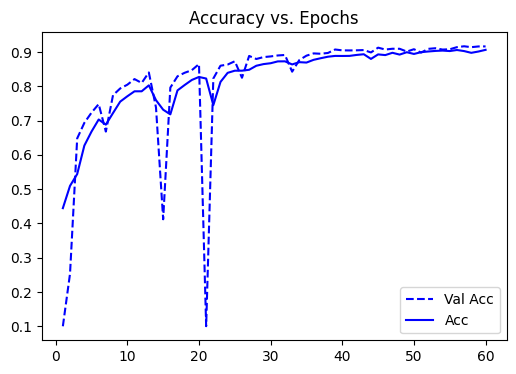

In [ ]:
import matplotlib.pyplot as plt

no_epochs = len(hist_distil1['sparse_categorical_accuracy'])

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
ax.plot(range(1, no_epochs + 1), hist_distil1['val_sparse_categorical_accuracy'], label='Val Acc', ls='--', color='blue')
ax.plot(range(1, no_epochs + 1), hist_distil1['sparse_categorical_accuracy'], label='Acc', ls='-', color='blue')
ax.legend()
ax.set_title("Accuracy vs. Epochs")

In [ ]:
import pandas as pd

df = pd.DataFrame(hist_distil1)
df.to_csv('hist_distil1.csv', index=False)

In [ ]:
# small2
# Create Teacher
#teacher_model = model_mobilenet
teacher_model = tf.keras.models.load_model("model_mobilenet.h5")
teacher_model.compile(loss=SparseCategoricalCrossentropy(from_logits=True),
              optimizer=SGD(learning_rate=0.1, momentum=0.9, weight_decay=0.0, nesterov=False),
              metrics=['accuracy'])
teacher_model.evaluate(test_data)
teacher_model.trainable = False

input_shape = (32, 32, 3)
num_classes = 10

# Create Student
student_model = small2_mobilenet_v2_like()

# Distill teacher to student
# Initialize and compile distiller
distiller = Distiller(student=student_model, teacher=teacher_model)
distiller.compile(
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    distillation_loss_fn=tf.keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=10,
)

# Distill teacher to student
distiller.fit(train_data, validation_data=test_data, epochs=60)

79/79 [==============================] - 4s 11ms/step - loss: 0.2421 - accuracy: 0.9289
Epoch 1/60
391/391 [==============================] - 32s 30ms/step - sparse_categorical_accuracy: 0.4558 - student_loss: 2.8043 - distillation_loss: 13.5374 - val_sparse_categorical_accuracy: 0.1000 - val_student_loss: 7.9800
Epoch 2/60
391/391 [==============================] - 18s 45ms/step - sparse_categorical_accuracy: 0.5958 - student_loss: 2.0272 - distillation_loss: 8.7274 - val_sparse_categorical_accuracy: 0.6731 - val_student_loss: 2.2531
Epoch 3/60
391/391 [==============================] - 9s 24ms/step - sparse_categorical_accuracy: 0.6410 - student_loss: 1.8190 - distillation_loss: 7.4541 - val_sparse_categorical_accuracy: 0.7122 - val_student_loss: 1.4126
Epoch 4/60
391/391 [==============================] - 9s 24ms/step - sparse_categorical_accuracy: 0.6641 - student_loss: 1.7634 - distillation_loss: 6.8400 - val_sparse_categorical_accuracy: 0.7246 - val_student_loss: 1.5626
Epoch 5/6

In [ ]:
tf.keras.models.save_model(distiller.student, "model_student2.h5", include_optimizer=False)

hist_distil2 = distiller.history.history
#hist_student = distiller.student.history.history

print(f"Total params: {distiller.student.count_params()}")

Total params: 1303322


<ipython-input-19-f95a2f057f54>:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(distiller.student, "model_student2.h5", include_optimizer=False)


In [ ]:
distiller.student.evaluate(test_data)

79/79 [==============================] - 2s 8ms/step - loss: 1.3715 - sparse_categorical_accuracy: 0.8926


[1.371538758277893, 0.8925999999046326]

In [ ]:
print(f"Student2 model size (bytes): {get_gzipped_model_size('model_student2.h5')}")
print("Baseline model size (bytes):", get_gzipped_model_size("model_mobilenet.h5"))

Student2 model size (bytes): 4872856
Baseline model size (bytes): 8678813


In [ ]:
import pandas as pd

df = pd.DataFrame(hist_distil2)
df.to_csv('hist_distil2.csv', index=False)

In [ ]:
# small 3
# Create Teacher
#teacher_model = model_mobilenet
teacher_model = tf.keras.models.load_model("model_mobilenet.h5")
teacher_model.compile(loss=SparseCategoricalCrossentropy(from_logits=True),
              optimizer=SGD(learning_rate=0.1, momentum=0.9, weight_decay=0.0, nesterov=False),
              metrics=['accuracy'])
teacher_model.evaluate(test_data)
teacher_model.trainable = False

input_shape = (32, 32, 3)
num_classes = 10

# Create Student
student_model = small3_mobilenet_v2_like()

# Distill teacher to student
# Initialize and compile distiller
distiller = Distiller(student=student_model, teacher=teacher_model)
distiller.compile(
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    distillation_loss_fn=tf.keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=10,
)

# Distill teacher to student
distiller.fit(train_data, validation_data=test_data, epochs=60)

79/79 [==============================] - 4s 11ms/step - loss: 0.2421 - accuracy: 0.9289
Epoch 1/60
391/391 [==============================] - 22s 22ms/step - sparse_categorical_accuracy: 0.4395 - student_loss: 2.4296 - distillation_loss: 14.3418 - val_sparse_categorical_accuracy: 0.1074 - val_student_loss: 7.7093
Epoch 2/60
391/391 [==============================] - 13s 34ms/step - sparse_categorical_accuracy: 0.5500 - student_loss: 2.0424 - distillation_loss: 10.5600 - val_sparse_categorical_accuracy: 0.5240 - val_student_loss: 2.7956
Epoch 3/60
391/391 [==============================] - 6s 17ms/step - sparse_categorical_accuracy: 0.6022 - student_loss: 1.8965 - distillation_loss: 8.9257 - val_sparse_categorical_accuracy: 0.6341 - val_student_loss: 1.6785
Epoch 4/60
391/391 [==============================] - 6s 16ms/step - sparse_categorical_accuracy: 0.6330 - student_loss: 1.8346 - distillation_loss: 7.9476 - val_sparse_categorical_accuracy: 0.6410 - val_student_loss: 1.6004
Epoch 5/

In [ ]:
tf.keras.models.save_model(distiller.student, "model_student3.h5", include_optimizer=False)

hist_distil3 = distiller.history.history
#hist_student = distiller.student.history.history

print(f"Total params: {distiller.student.count_params()}")

Total params: 635242


<ipython-input-23-16819fb2206e>:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(distiller.student, "model_student3.h5", include_optimizer=False)


In [ ]:
distiller.student.evaluate(test_data)

79/79 [==============================] - 1s 5ms/step - loss: 1.6962 - sparse_categorical_accuracy: 0.8717


[1.6961795091629028, 0.8716999888420105]

In [ ]:
print(f"Student3 model size (bytes): {get_gzipped_model_size('model_student3.h5')}")
print("Baseline model size (bytes):", get_gzipped_model_size("model_mobilenet.h5"))

Student3 model size (bytes): 2373536
Baseline model size (bytes): 8678813


In [ ]:
import pandas as pd

df = pd.DataFrame(hist_distil3)
df.to_csv('hist_distil3.csv', index=False)

<function matplotlib.pyplot.show(close=None, block=None)>

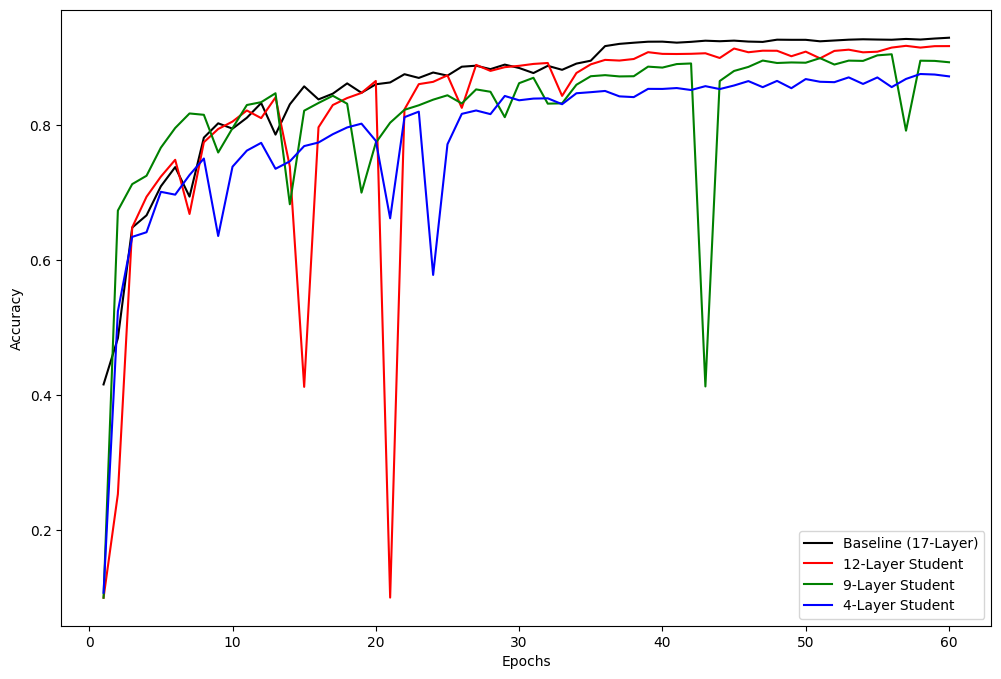

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

df_baseline = pd.read_csv("hist_mobilenet.csv")
df_distil1 = pd.read_csv("hist_distil.csv")
df_distil2 = pd.read_csv("hist_distil2.csv")
df_distil3 = pd.read_csv("hist_distil3.csv")

no_epochs = len(df_baseline['accuracy'])

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)

ax.plot(range(1, no_epochs + 1), df_baseline['val_accuracy'], label='Baseline (17-Layer)', ls='-', color='black')
ax.plot(range(1, no_epochs + 1), df_distil1['val_sparse_categorical_accuracy'], label='12-Layer Student', ls='-', color='red')
ax.plot(range(1, no_epochs + 1), df_distil2['val_sparse_categorical_accuracy'], label='9-Layer Student', ls='-', color='green')
ax.plot(range(1, no_epochs + 1), df_distil3['val_sparse_categorical_accuracy'], label='4-Layer Student', ls='-', color='blue')

# ax.plot(range(1, no_epochs + 1), df_baseline['accuracy'], label='Baseline (17-Layer)', ls='-', color='black')
# ax.plot(range(1, no_epochs + 1), df_distil1['sparse_categorical_accuracy'], label='12-Layer Student', ls='-', color='red')
# ax.plot(range(1, no_epochs + 1), df_distil2['sparse_categorical_accuracy'], label='9-Layer Student', ls='-', color='green')
# ax.plot(range(1, no_epochs + 1), df_distil3['sparse_categorical_accuracy'], label='4-Layer Student', ls='-', color='blue')

ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
#ax.set_ylim(0.5, 1.0)
ax.legend()
#ax.set_title("Validation Accuracy vs. Epochs")

plt.savefig('kd-val-acc.png', bbox_inches='tight')
plt.show

#Pruning

In [ ]:
model_mobilenet.evaluate(test_data)
#model_mobilenet.summary()
print(f"Total params: {model_mobilenet.count_params()}")
#tf.keras.models.save_model(model_mobilenet, "keras_file.h5", include_optimizer=False)
model = model_mobilenet

79/79 [==============================] - 1s 14ms/step - loss: 0.2422 - accuracy: 0.9289
Total params: 2330186


In [ ]:
model = tf.keras.models.load_model("model_mobilenet.h5")
model.compile(loss=SparseCategoricalCrossentropy(from_logits=True),
              optimizer=SGD(learning_rate=0.1, momentum=0.9, weight_decay=0.0, nesterov=False),
              metrics=['accuracy'])
model.evaluate(test_data)
print(f"Total params: {model_mobilenet.count_params()}")

79/79 [==============================] - 4s 13ms/step - loss: 0.2421 - accuracy: 0.9289
Total params: 2330186


In [ ]:
# Sparsity = 0.80
import tensorflow_model_optimization as tfmot
import tempfile
import os

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 128
epochs = 12
#validation_split = 0.1 # 10% of training set will be used for validation set.

num_images = x_train.shape[0] #* (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80, #0.80,
                                                               begin_step=0,
                                                               end_step=end_step)
}

model_for_pruning = prune_low_magnitude(model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer=SGD(learning_rate=0.1, momentum=0.9, weight_decay=0.0, nesterov=False), #'adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#model_for_pruning.summary()

In [ ]:
logdir = "./tfmot_logs" #tempfile.mkdtemp()

model_for_pruning.fit(train_data,
                  epochs=epochs, validation_data=test_data, #validation_split=validation_split,
                  callbacks=[tfmot.sparsity.keras.UpdatePruningStep(),
                             tfmot.sparsity.keras.PruningSummaries(log_dir=logdir)]
                      )

Epoch 1/12
  6/391 [..............................] - ETA: 25s - loss: 0.1272 - accuracy: 0.9596

391/391 [==============================] - 89s 88ms/step - loss: 0.2756 - accuracy: 0.9024 - val_loss: 0.3037 - val_accuracy: 0.8984
Epoch 2/12
391/391 [==============================] - 36s 93ms/step - loss: 0.2859 - accuracy: 0.8978 - val_loss: 0.3183 - val_accuracy: 0.8941
Epoch 3/12
391/391 [==============================] - 28s 73ms/step - loss: 0.2919 - accuracy: 0.8950 - val_loss: 0.3369 - val_accuracy: 0.8891
Epoch 4/12
391/391 [==============================] - 28s 70ms/step - loss: 0.2931 - accuracy: 0.8959 - val_loss: 0.3206 - val_accuracy: 0.8914
Epoch 5/12
391/391 [==============================] - 28s 71ms/step - loss: 0.2967 - accuracy: 0.8931 - val_loss: 0.3601 - val_accuracy: 0.8815
Epoch 6/12
391/391 [==============================] - 27s 70ms/step - loss: 0.2887 - accuracy: 0.8973 - val_loss: 0.3287 - val_accuracy: 0.8915
Epoch 7/12
391/391 [==============================] - 28s 71ms/step - loss: 0.2912 - accuracy: 0.8949 - val_loss: 0.3242 - val_accuracy: 0.8901
Epo

In [ ]:
model_for_pruning.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 prune_low_magnitude_Conv1   (None, 32, 32, 32)           1730      ['input_1[0][0]']             
 (PruneLowMagnitude)                                                                              
                                                                                                  
 prune_low_magnitude_bn_Con  (None, 32, 32, 32)           129       ['prune_low_magnitude_Conv1[0]
 v1 (PruneLowMagnitude)                                             [0]']                         
                                                                                              

In [ ]:
tf.keras.models.save_model(model_for_pruning, "model_for_pruning80.h5", include_optimizer=False)

hist_for_pruning80 = model_for_pruning.history.history

import pandas as pd

df = pd.DataFrame(hist_for_pruning80)
df.to_csv('hist_for_pruning80.csv', index=False)

print(f"Total params: {model_for_pruning.count_params()}")
model_for_pruning.evaluate(test_data)

<ipython-input-16-672c4e65d1d9>:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_pruning, "model_for_pruning80.h5", include_optimizer=False)


Total params: 4527989
79/79 [==============================] - 1s 12ms/step - loss: 0.2953 - accuracy: 0.9046


[0.2952952980995178, 0.9046000242233276]

In [ ]:
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
# model_for_export.compile(optimizer=SGD(learning_rate=0.1, momentum=0.9, weight_decay=0.0, nesterov=False), #'adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])
# model_for_export.evaluate(test_data)

tf.keras.models.save_model(model_for_export, "model_pruned80.h5", include_optimizer=False)

<ipython-input-18-361131d00e51>:7: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, "model_pruned80.h5", include_optimizer=False)


In [ ]:
model_for_export.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 32, 32, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 32, 32, 32)           128       ['Conv1[1][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 32, 32, 32)           0         ['bn_Conv1[1][0]']        

In [ ]:
print(f"Baseline model size (bytes): {get_gzipped_model_size('model_mobilenet.h5')}")
print(f"Model for pruning size (bytes): {get_gzipped_model_size('model_for_pruning80.h5')}")
print(f"Pruned model (sparsity=0.8) size (bytes): {get_gzipped_model_size('model_pruned80.h5')}")

Baseline model size (bytes): 8678813
Model for pruning size (bytes): 3625837
Pruned model (sparsity=0.8) size (bytes): 3142002


In [ ]:
print(f"Baseline model size (bytes): {get_gzipped_model_size('model_mobilenet.h5')}")
#print(f"Model for pruning size (bytes): {get_gzipped_model_size('model_for_pruning.h5')}")
print(f"Pruned model (sparsity=0.8) size (bytes): {get_gzipped_model_size('model_pruned80.h5')}")

Baseline model size (bytes): 8678813
Pruned model (sparsity=0.8) size (bytes): 3142002


In [ ]:
model_for_pruning.evaluate(test_data)

79/79 [==============================] - 1s 11ms/step - loss: 0.2953 - accuracy: 0.9046


[0.2952952980995178, 0.9046000242233276]

In [ ]:
# Sparsity 0.70
model = tf.keras.models.load_model("model_mobilenet.h5")
model.compile(loss=SparseCategoricalCrossentropy(from_logits=True),
              optimizer=SGD(learning_rate=0.1, momentum=0.9, weight_decay=0.0, nesterov=False),
              metrics=['accuracy'])
model.evaluate(test_data)
print(f"Total params: {model_mobilenet.count_params()}")

import tensorflow_model_optimization as tfmot
import tempfile
import os

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 128
epochs = 12
#validation_split = 0.1 # 10% of training set will be used for validation set.

num_images = x_train.shape[0] #* (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.70, #0.80,
                                                               begin_step=0,
                                                               end_step=end_step)
}

model_for_pruning = prune_low_magnitude(model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer=SGD(learning_rate=0.1, momentum=0.9, weight_decay=0.0, nesterov=False), #'adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

logdir = "./tfmot_logs" #tempfile.mkdtemp()

model_for_pruning.fit(train_data,
                  epochs=epochs, validation_data=test_data, #validation_split=validation_split,
                  callbacks=[tfmot.sparsity.keras.UpdatePruningStep(),
                             tfmot.sparsity.keras.PruningSummaries(log_dir=logdir)]
                      )

79/79 [==============================] - 10s 18ms/step - loss: 0.2421 - accuracy: 0.9289
Total params: 2330186
Epoch 1/12
  6/391 [..............................] - ETA: 26s - loss: 0.1313 - accuracy: 0.9453

391/391 [==============================] - 99s 97ms/step - loss: 0.2674 - accuracy: 0.9031 - val_loss: 0.3419 - val_accuracy: 0.8905
Epoch 2/12
391/391 [==============================] - 45s 115ms/step - loss: 0.2684 - accuracy: 0.9043 - val_loss: 0.3726 - val_accuracy: 0.8844
Epoch 3/12
391/391 [==============================] - 27s 70ms/step - loss: 0.2704 - accuracy: 0.9050 - val_loss: 0.3118 - val_accuracy: 0.9009
Epoch 4/12
391/391 [==============================] - 27s 68ms/step - loss: 0.2688 - accuracy: 0.9042 - val_loss: 0.2979 - val_accuracy: 0.8997
Epoch 5/12
391/391 [==============================] - 27s 69ms/step - loss: 0.2615 - accuracy: 0.9069 - val_loss: 0.3660 - val_accuracy: 0.8855
Epoch 6/12
391/391 [==============================] - 27s 68ms/step - loss: 0.2612 - accuracy: 0.9073 - val_loss: 0.3207 - val_accuracy: 0.8958
Epoch 7/12
391/391 [==============================] - 27s 68ms/step - loss: 0.2536 - accuracy: 0.9100 - val_loss: 0.3101 - val_accuracy: 0.9015
Ep

In [ ]:
model_for_pruning.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 prune_low_magnitude_Conv1   (None, 32, 32, 32)           1730      ['input_1[0][0]']             
 (PruneLowMagnitude)                                                                              
                                                                                                  
 prune_low_magnitude_bn_Con  (None, 32, 32, 32)           129       ['prune_low_magnitude_Conv1[0]
 v1 (PruneLowMagnitude)                                             [0]']                         
                                                                                              

In [ ]:
tf.keras.models.save_model(model_for_pruning, "model_for_pruning70.h5", include_optimizer=False)

hist_for_pruning70 = model_for_pruning.history.history

import pandas as pd

df = pd.DataFrame(hist_for_pruning70)
df.to_csv('hist_for_pruning70.csv', index=False)

print(f"Total params: {model_for_pruning.count_params()}")
model_for_pruning.evaluate(test_data)

model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
# model_for_export.compile(optimizer=SGD(learning_rate=0.1, momentum=0.9, weight_decay=0.0, nesterov=False), #'adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])
# model_for_export.evaluate(test_data)

tf.keras.models.save_model(model_for_export, "model_pruned70.h5", include_optimizer=False)

<ipython-input-10-6aba5a0cf5ea>:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_pruning, "model_for_pruning70.h5", include_optimizer=False)


Total params: 4527989
79/79 [==============================] - 1s 11ms/step - loss: 0.3015 - accuracy: 0.9059


<ipython-input-10-6aba5a0cf5ea>:19: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, "model_pruned70.h5", include_optimizer=False)


In [ ]:
print(f"Baseline model size (bytes): {get_gzipped_model_size('model_mobilenet.h5')}")
#print(f"Model for pruning size (bytes): {get_gzipped_model_size('model_for_pruning70.h5')}")
print(f"Pruned model (sparsity=0.7) size (bytes): {get_gzipped_model_size('model_pruned70.h5')}")

Baseline model size (bytes): 8678813
Pruned model (sparsity=0.7) size (bytes): 3976862


In [ ]:
# Sparsity 0.6
model = tf.keras.models.load_model("model_mobilenet.h5")
model.compile(loss=SparseCategoricalCrossentropy(from_logits=True),
              optimizer=SGD(learning_rate=0.1, momentum=0.9, weight_decay=0.0, nesterov=False),
              metrics=['accuracy'])
model.evaluate(test_data)
print(f"Total params: {model_mobilenet.count_params()}")

import tensorflow_model_optimization as tfmot
import tempfile
import os

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 128
epochs = 12
#validation_split = 0.1 # 10% of training set will be used for validation set.

num_images = x_train.shape[0] #* (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.60,
                                                               begin_step=0,
                                                               end_step=end_step)
}

model_for_pruning = prune_low_magnitude(model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer=SGD(learning_rate=0.1, momentum=0.9, weight_decay=0.0, nesterov=False), #'adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

logdir = "./tfmot_logs" #tempfile.mkdtemp()

model_for_pruning.fit(train_data,
                  epochs=epochs, validation_data=test_data, #validation_split=validation_split,
                  callbacks=[tfmot.sparsity.keras.UpdatePruningStep(),
                             tfmot.sparsity.keras.PruningSummaries(log_dir=logdir)]
                      )

79/79 [==============================] - 4s 12ms/step - loss: 0.2421 - accuracy: 0.9289
Total params: 2330186
Epoch 1/12
  6/391 [..............................] - ETA: 26s - loss: 0.1198 - accuracy: 0.9570

391/391 [==============================] - 86s 86ms/step - loss: 0.2580 - accuracy: 0.9080 - val_loss: 0.3062 - val_accuracy: 0.8994
Epoch 2/12
391/391 [==============================] - 36s 93ms/step - loss: 0.2564 - accuracy: 0.9062 - val_loss: 0.3612 - val_accuracy: 0.8881
Epoch 3/12
391/391 [==============================] - 27s 70ms/step - loss: 0.2560 - accuracy: 0.9092 - val_loss: 0.3921 - val_accuracy: 0.8767
Epoch 4/12
391/391 [==============================] - 27s 70ms/step - loss: 0.2452 - accuracy: 0.9123 - val_loss: 0.3020 - val_accuracy: 0.9009
Epoch 5/12
391/391 [==============================] - 27s 69ms/step - loss: 0.2385 - accuracy: 0.9157 - val_loss: 0.2893 - val_accuracy: 0.9059
Epoch 6/12
391/391 [==============================] - 27s 69ms/step - loss: 0.2351 - accuracy: 0.9166 - val_loss: 0.3064 - val_accuracy: 0.9001
Epoch 7/12
391/391 [==============================] - 27s 70ms/step - loss: 0.2319 - accuracy: 0.9162 - val_loss: 0.3014 - val_accuracy: 0.9059
Epo

In [ ]:
tf.keras.models.save_model(model_for_pruning, "model_for_pruning60.h5", include_optimizer=False)

hist_for_pruning60 = model_for_pruning.history.history

import pandas as pd

df = pd.DataFrame(hist_for_pruning60)
df.to_csv('hist_for_pruning60.csv', index=False)

print(f"Total params: {model_for_pruning.count_params()}")
model_for_pruning.evaluate(test_data)

model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
# model_for_export.compile(optimizer=SGD(learning_rate=0.1, momentum=0.9, weight_decay=0.0, nesterov=False), #'adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])
# model_for_export.evaluate(test_data)

tf.keras.models.save_model(model_for_export, "model_pruned60.h5", include_optimizer=False)

<ipython-input-31-ce91722647a0>:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_pruning, "model_for_pruning60.h5", include_optimizer=False)


Total params: 4527989
79/79 [==============================] - 1s 11ms/step - loss: 0.2920 - accuracy: 0.9115


<ipython-input-31-ce91722647a0>:19: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, "model_pruned60.h5", include_optimizer=False)


In [ ]:
print(f"Baseline model size (bytes): {get_gzipped_model_size('model_mobilenet.h5')}")
#print(f"Model for pruning size (bytes): {get_gzipped_model_size('model_for_pruning60.h5')}")
print(f"Pruned model (sparsity=0.6) size (bytes): {get_gzipped_model_size('model_pruned60.h5')}")

Baseline model size (bytes): 8678813
Pruned model (sparsity=0.6) size (bytes): 4767631


In [ ]:
# Sparsity 0.9
model = tf.keras.models.load_model("model_mobilenet.h5")
model.compile(loss=SparseCategoricalCrossentropy(from_logits=True),
              optimizer=SGD(learning_rate=0.1, momentum=0.9, weight_decay=0.0, nesterov=False),
              metrics=['accuracy'])
model.evaluate(test_data)
print(f"Total params: {model_mobilenet.count_params()}")

import tensorflow_model_optimization as tfmot
import tempfile
import os

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 128
epochs = 12
#validation_split = 0.1 # 10% of training set will be used for validation set.

num_images = x_train.shape[0] #* (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.90, #
                                                               begin_step=0,
                                                               end_step=end_step)
}

model_for_pruning = prune_low_magnitude(model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer=SGD(learning_rate=0.1, momentum=0.9, weight_decay=0.0, nesterov=False), #'adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

logdir = "./tfmot_logs" #tempfile.mkdtemp()

model_for_pruning.fit(train_data,
                  epochs=epochs, validation_data=test_data, #validation_split=validation_split,
                  callbacks=[tfmot.sparsity.keras.UpdatePruningStep(),
                             tfmot.sparsity.keras.PruningSummaries(log_dir=logdir)]
                      )

79/79 [==============================] - 4s 11ms/step - loss: 0.2421 - accuracy: 0.9289
Total params: 2330186
Epoch 1/12
  6/391 [..............................] - ETA: 26s - loss: 0.1257 - accuracy: 0.9440

391/391 [==============================] - 87s 89ms/step - loss: 0.2687 - accuracy: 0.9054 - val_loss: 0.3397 - val_accuracy: 0.8869
Epoch 2/12
391/391 [==============================] - 36s 91ms/step - loss: 0.3001 - accuracy: 0.8922 - val_loss: 0.3057 - val_accuracy: 0.8960
Epoch 3/12
391/391 [==============================] - 27s 70ms/step - loss: 0.3116 - accuracy: 0.8885 - val_loss: 0.3157 - val_accuracy: 0.8931
Epoch 4/12
391/391 [==============================] - 27s 70ms/step - loss: 0.3376 - accuracy: 0.8816 - val_loss: 0.3354 - val_accuracy: 0.8872
Epoch 5/12
391/391 [==============================] - 28s 71ms/step - loss: 0.3441 - accuracy: 0.8774 - val_loss: 0.3591 - val_accuracy: 0.8774
Epoch 6/12
391/391 [==============================] - 28s 71ms/step - loss: 0.3670 - accuracy: 0.8709 - val_loss: 0.3655 - val_accuracy: 0.8790
Epoch 7/12
391/391 [==============================] - 28s 72ms/step - loss: 0.3827 - accuracy: 0.8645 - val_loss: 0.4028 - val_accuracy: 0.8615
Epo

In [ ]:
tf.keras.models.save_model(model_for_pruning, "model_for_pruning90.h5", include_optimizer=False)

hist_for_pruning90 = model_for_pruning.history.history

import pandas as pd

df = pd.DataFrame(hist_for_pruning90)
df.to_csv('hist_for_pruning90.csv', index=False)

print(f"Total params: {model_for_pruning.count_params()}")
model_for_pruning.evaluate(test_data)

model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
# model_for_export.compile(optimizer=SGD(learning_rate=0.1, momentum=0.9, weight_decay=0.0, nesterov=False), #'adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])
# model_for_export.evaluate(test_data)

tf.keras.models.save_model(model_for_export, "model_pruned90.h5", include_optimizer=False)

<ipython-input-45-19ab1358a1d2>:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_pruning, "model_for_pruning90.h5", include_optimizer=False)


Total params: 4527989
79/79 [==============================] - 1s 12ms/step - loss: 0.3622 - accuracy: 0.8807


<ipython-input-45-19ab1358a1d2>:19: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, "model_pruned90.h5", include_optimizer=False)


In [ ]:
print(f"Baseline model size (bytes): {get_gzipped_model_size('model_mobilenet.h5')}")
#print(f"Model for pruning size (bytes): {get_gzipped_model_size('model_for_pruning60.h5')}")
print(f"Pruned model (sparsity=0.9) size (bytes): {get_gzipped_model_size('model_pruned90.h5')}")

Baseline model size (bytes): 8678813
Pruned model (sparsity=0.9) size (bytes): 2248330


In [ ]:
# Sparsity 0.95
model = tf.keras.models.load_model("model_mobilenet.h5")
model.compile(loss=SparseCategoricalCrossentropy(from_logits=True),
              optimizer=SGD(learning_rate=0.1, momentum=0.9, weight_decay=0.0, nesterov=False),
              metrics=['accuracy'])
model.evaluate(test_data)
print(f"Total params: {model_mobilenet.count_params()}")

import tensorflow_model_optimization as tfmot
import tempfile
import os

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 128
epochs = 12
#validation_split = 0.1 # 10% of training set will be used for validation set.

num_images = x_train.shape[0] #* (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.95, #
                                                               begin_step=0,
                                                               end_step=end_step)
}

model_for_pruning = prune_low_magnitude(model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer=SGD(learning_rate=0.1, momentum=0.9, weight_decay=0.0, nesterov=False), #'adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

logdir = "./tfmot_logs" #tempfile.mkdtemp()

model_for_pruning.fit(train_data,
                  epochs=epochs, validation_data=test_data, #validation_split=validation_split,
                  callbacks=[tfmot.sparsity.keras.UpdatePruningStep(),
                             tfmot.sparsity.keras.PruningSummaries(log_dir=logdir)]
                      )

79/79 [==============================] - 4s 11ms/step - loss: 0.2421 - accuracy: 0.9289
Total params: 2330186
Epoch 1/12
  6/391 [..............................] - ETA: 25s - loss: 0.1500 - accuracy: 0.9518

391/391 [==============================] - 86s 86ms/step - loss: 0.2748 - accuracy: 0.9017 - val_loss: 0.3024 - val_accuracy: 0.8980
Epoch 2/12
391/391 [==============================] - 35s 90ms/step - loss: 0.3061 - accuracy: 0.8918 - val_loss: 0.3687 - val_accuracy: 0.8800
Epoch 3/12
391/391 [==============================] - 27s 69ms/step - loss: 0.3336 - accuracy: 0.8810 - val_loss: 0.3333 - val_accuracy: 0.8880
Epoch 4/12
391/391 [==============================] - 27s 69ms/step - loss: 0.3581 - accuracy: 0.8739 - val_loss: 0.3525 - val_accuracy: 0.8795
Epoch 5/12
391/391 [==============================] - 27s 69ms/step - loss: 0.3960 - accuracy: 0.8616 - val_loss: 0.3758 - val_accuracy: 0.8714
Epoch 6/12
391/391 [==============================] - 27s 69ms/step - loss: 0.4360 - accuracy: 0.8463 - val_loss: 0.5027 - val_accuracy: 0.8323
Epoch 7/12
391/391 [==============================] - 27s 69ms/step - loss: 0.4815 - accuracy: 0.8312 - val_loss: 0.6114 - val_accuracy: 0.7888
Epo

In [ ]:
tf.keras.models.save_model(model_for_pruning, "model_for_pruning95.h5", include_optimizer=False)

hist_for_pruning95 = model_for_pruning.history.history

import pandas as pd

df = pd.DataFrame(hist_for_pruning95)
df.to_csv('hist_for_pruning95.csv', index=False)

print(f"Total params: {model_for_pruning.count_params()}")
model_for_pruning.evaluate(test_data)

model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
# model_for_export.compile(optimizer=SGD(learning_rate=0.1, momentum=0.9, weight_decay=0.0, nesterov=False), #'adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])
# model_for_export.evaluate(test_data)

tf.keras.models.save_model(model_for_export, "model_pruned95.h5", include_optimizer=False)

<ipython-input-57-3ade2aa15002>:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_pruning, "model_for_pruning95.h5", include_optimizer=False)


Total params: 4527989
79/79 [==============================] - 1s 11ms/step - loss: 2.6033 - accuracy: 0.3200


<ipython-input-57-3ade2aa15002>:19: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, "model_pruned95.h5", include_optimizer=False)


In [ ]:
print(f"Baseline model size (bytes): {get_gzipped_model_size('model_mobilenet.h5')}")
#print(f"Model for pruning size (bytes): {get_gzipped_model_size('model_for_pruning60.h5')}")
print(f"Pruned model (sparsity=0.95) size (bytes): {get_gzipped_model_size('model_pruned95.h5')}")

Baseline model size (bytes): 8678813
Pruned model (sparsity=0.95) size (bytes): 1756749


###Analysis of weight distribution

In [ ]:
weights = []
for i in model_for_pruning.get_weights():
#for i in m.get_weights():
    tmp = i.reshape(-1)
    for j in tmp:
        weights.append(j)

weights = np.array(weights)
#weights = weights.flatten()
print(weights.shape, weights.min(), weights.max())

(4527989,) -7622.1728515625 299940160.0


In [ ]:
weights.mean()

120.77991916309574

In [ ]:
noz = len(weights) - np.count_nonzero(weights)
print(f"{noz} zeros out of {len(weights)}")

4175424 zeros out of 4527989


In [ ]:
import pandas as pd

df = pd.DataFrame({"weights": weights})
df.to_csv('weights_after_pruning95.csv', index=False)

In [ ]:
m = tf.keras.models.load_model("model_mobilenet.h5")

In [ ]:
weights = []
#for i in model_for_pruning.get_weights():
for i in m.get_weights():
    tmp = i.reshape(-1)
    for j in tmp:
        weights.append(j)

weights = np.array(weights)
#weights = weights.flatten()
print(weights.shape, weights.min(), weights.max())

(2330186,) -85.66016 894.27356


In [ ]:
weights.mean()

0.14117032

In [ ]:
noz = len(weights) - np.count_nonzero(weights)
print(f"{noz} zeros out of {len(weights)}")

0 zeros out of 2330186


In [ ]:
df = pd.DataFrame({"weights": weights})
df.to_csv('weights_baseline.csv', index=False)

In [ ]:
weights = []
for i in model_for_export.get_weights():
#for i in m.get_weights():
    tmp = i.reshape(-1)
    for j in tmp:
        weights.append(j)

weights = np.array(weights)
#weights = weights.flatten()
print(weights.shape, weights.min(), weights.max())

(2330186,) -7622.173 299940160.0


In [ ]:
weights.mean()

234.3247

In [ ]:
noz = len(weights) - np.count_nonzero(weights)
print(f"{noz} zeros out of {len(weights)}")

2087712 zeros out of 2330186


In [ ]:
df = pd.DataFrame({"weights": weights})
df.to_csv('weights_after_pruning(export)95.csv', index=False)

In [ ]:
hist_for_pruning60

Text(0.5, 1.0, 'Accuracy vs. Epochs')

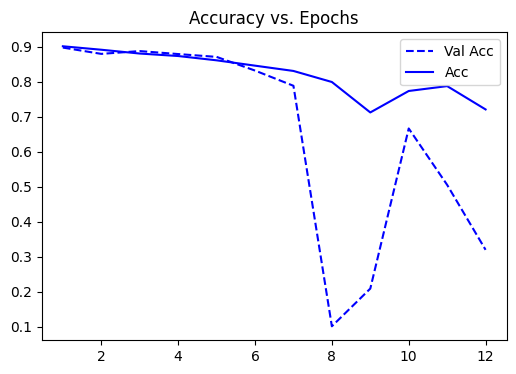

In [ ]:
import matplotlib.pyplot as plt

no_epochs = len(hist_for_pruning95["accuracy"])

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
ax.plot(range(1, no_epochs + 1), hist_for_pruning95['val_accuracy'], label='Val Acc', ls='--', color='blue')
ax.plot(range(1, no_epochs + 1), hist_for_pruning95['accuracy'], label='Acc', ls='-', color='blue')
ax.legend()
ax.set_title("Accuracy vs. Epochs")

In [ ]:
import pandas as pd

df_list = []
df60 = pd.read_csv("/content/hist_for_pruning60.csv")
df70 = pd.read_csv("/content/hist_for_pruning70.csv")
df80 = pd.read_csv("/content/hist_for_pruning80.csv")
df90 = pd.read_csv("/content/hist_for_pruning90.csv")
df95 = pd.read_csv("/content/hist_for_pruning95.csv")
df_list.append(df60)
df_list.append(df70)
df_list.append(df80)
df_list.append(df90)
df_list.append(df95)

In [ ]:
tmp = [0.9289]
[ tmp.append(df['val_accuracy'].iloc[-1]) for df in df_list]
data = {
    #"Initial Validation Accuracy":[df['val_accuracy'].iloc[0] for df in df_list],
    "Final Validation Accuracy": tmp
}

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def grouped_plot(data, title):

    x = np.arange(len(data["Final Validation Accuracy"]))  # the label locations
    width = 0.17  # the width of the bars
    multiplier = 0

    # plt.figure(figsize=(12,6))
    # fig, ax = plt.subplots(layout='constrained')
    fig = plt.figure(figsize=(10,4))
    ax = fig.add_subplot(111)

    for key, acc in data.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, acc, width, label=key)
        #ax.bar_label(rects, padding=6)
        multiplier += 1

    ax.plot(x,[data["Final Validation Accuracy"][0]]*6, ls='--', color='black')

    ax.set_ylabel('Accuracy')
    ax.set_title(title)
    #ax.set_xticks(x + width, feats) # use if multiple methods
    ax.set_xticks(x, labels=['Baseline', '60% Sparsity', '70% Sparsity', '80% Sparsity', '90% Sparsity', '95% Sparsity'])
    ax.set_yticks(np.arange(11)/10)#, np.arange(11))
    ###ax.legend()#loc='upper left')
    #ax.set_ylim(0, 250)

    plt.savefig('pruning-acc-trade-off.png', bbox_inches='tight')
    plt.show()


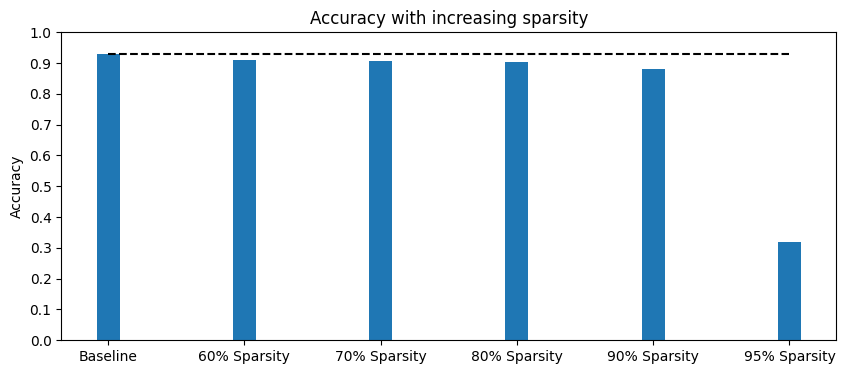

In [ ]:
grouped_plot(data, "Accuracy with increasing sparsity")

In [ ]:
import pandas as pd

df60 = pd.read_csv("/content/weights_after_pruning(export)60.csv")
print(len(df60))
df70 = pd.read_csv("/content/weights_after_pruning(export)70.csv")
print(len(df70))
df80 = pd.read_csv("/content/weights_after_pruning(export)80.csv")
print(len(df80))
df90 = pd.read_csv("/content/weights_after_pruning(export)90.csv")
print(len(df90))
df95 = pd.read_csv("/content/weights_after_pruning(export)95.csv")
print(len(df95))
df_baseline = pd.read_csv("/content/weights_baseline.csv")
print(len(df_baseline))

df = pd.DataFrame()
df['weights60'] = df60['weights']
df['weights70'] = df70['weights']
df['weights80'] = df80['weights']
df['weights90'] = df90['weights']
df['weights95'] = df95['weights']
df['weights_baseline'] = df_baseline['weights']

2330186
2330186
2330186
2330186
2330186
2330186


In [ ]:
print('No. non-zero baseline', len(df) - (df['weights_baseline'] == 0).sum())
print('No. non-zero weights60', len(df) - (df['weights60'] == 0).sum())
print('No. non-zero weights70', len(df) - (df['weights70'] == 0).sum())
print('No. non-zero weights80', len(df) - (df['weights80'] == 0).sum())
print('No. non-zero weights90', len(df) - (df['weights90'] == 0).sum())
print('No. non-zero weights95', len(df) - (df['weights95'] == 0).sum())


No. non-zero baseline 2330186
No. non-zero weights60 1011624
No. non-zero weights70 791868
No. non-zero weights80 572107
No. non-zero weights90 352351
No. non-zero weights95 242474


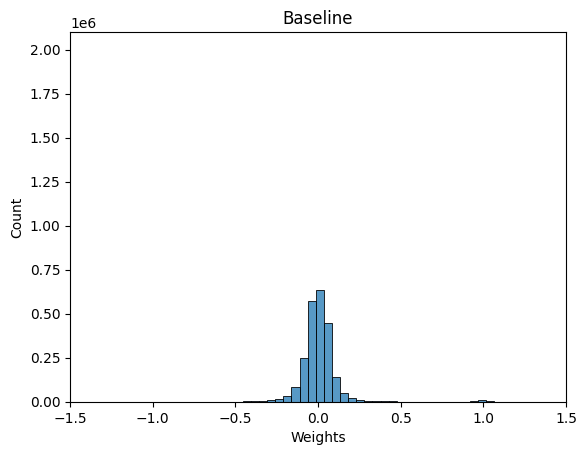

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.xlim(-1.5, 1.5)
plt.ylim(0, 2.1e6)
ax = sns.histplot(x=df['weights_baseline'], bins=20000)
ax.set(xlabel='Weights', ylabel='Count', title='Baseline')

plt.savefig('wt-baseline.png', bbox_inches='tight')
plt.show()

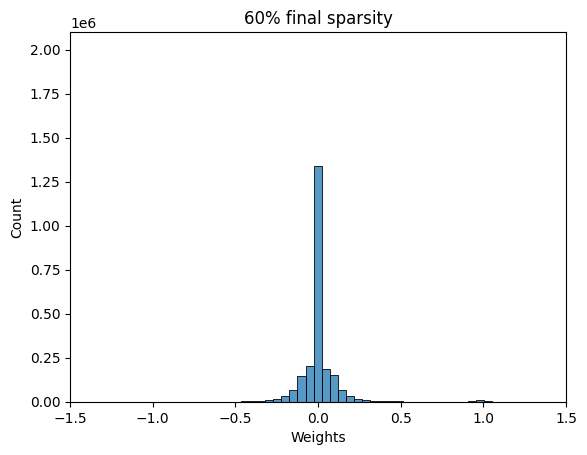

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.xlim(-1.5, 1.5)
plt.ylim(0, 2.1e6)
ax = sns.histplot(x=df['weights60'], bins=20000)
ax.set(xlabel='Weights', ylabel='Count', title='60% final sparsity')

plt.savefig('wt-dist60.png', bbox_inches='tight')
plt.show()

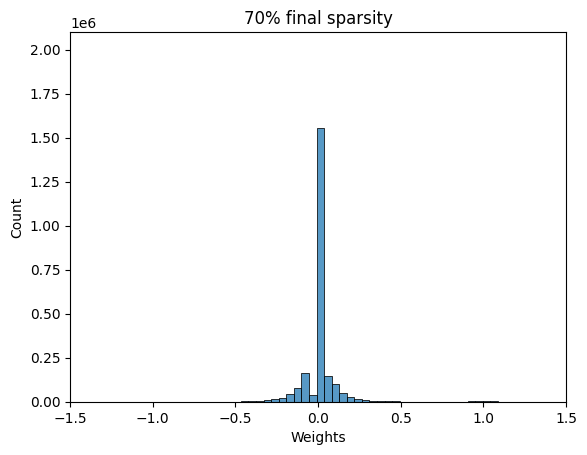

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.xlim(-1.5, 1.5)
plt.ylim(0, 2.1e6)
ax = sns.histplot(x=df['weights70'], bins=20000)
ax.set(xlabel='Weights', ylabel='Count', title='70% final sparsity')

plt.savefig('wt-dist70.png', bbox_inches='tight')
plt.show()

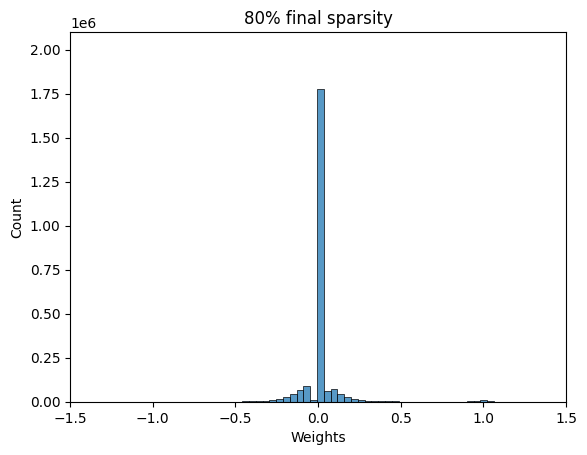

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.xlim(-1.5, 1.5)
plt.ylim(0, 2.1e6)
ax = sns.histplot(x=df['weights80'], bins=20000)
ax.set(xlabel='Weights', ylabel='Count', title='80% final sparsity')

plt.savefig('wt-dist80.png', bbox_inches='tight')
plt.show()

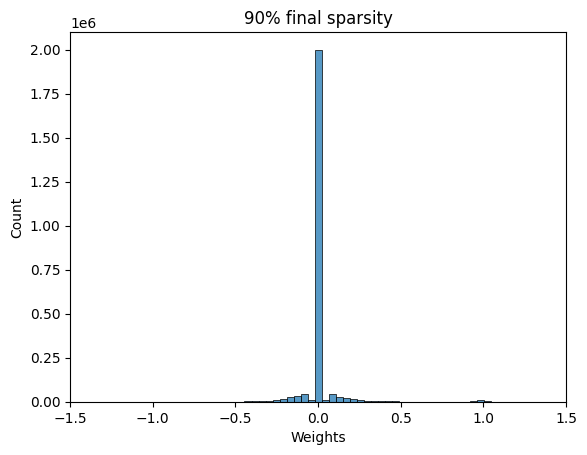

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.xlim(-1.5, 1.5)
plt.ylim(0, 2.1e6)
ax = sns.histplot(x=df['weights90'], bins=20000)
ax.set(xlabel='Weights', ylabel='Count', title='90% final sparsity')

plt.savefig('wt-dist90.png', bbox_inches='tight')
plt.show()

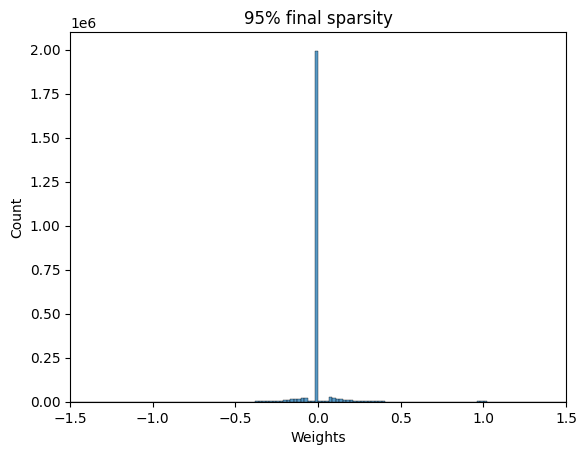

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.xlim(-1.5, 1.5)
plt.ylim(0, 2.1e6)
ax = sns.histplot(x=df['weights90'], bins=40000)
ax.set(xlabel='Weights', ylabel='Count', title='95% final sparsity')

plt.savefig('wt-dist95.png', bbox_inches='tight')
plt.show()

#Quantization

###QAT

In [9]:
import tensorflow_model_optimization as tfmot
import tempfile
import os

In [10]:
model_base = tf.keras.models.load_model("model_mobilenet.h5")
model_base.compile(loss=SparseCategoricalCrossentropy(from_logits=True),
              optimizer=SGD(learning_rate=0.1, momentum=0.9, weight_decay=0.0, nesterov=False),
              metrics=['accuracy'])
model_base.evaluate(test_data)

79/79 [==============================] - 10s 19ms/step - loss: 0.2421 - accuracy: 0.9289


[0.24213388562202454, 0.9289000034332275]

In [11]:
quantize_model = tfmot.quantization.keras.quantize_model

# q_aware stands for for quantization aware.
q_aware_model = quantize_model(model_base)

# `quantize_model` requires a recompile.
q_aware_model.compile(optimizer=SGD(learning_rate=0.1, momentum=0.9, weight_decay=0.0, nesterov=False),#'adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

q_aware_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 quantize_layer (QuantizeLa  (None, 32, 32, 3)            3         ['input_1[0][0]']             
 yer)                                                                                             
                                                                                                  
 quant_Conv1 (QuantizeWrapp  (None, 32, 32, 32)           929       ['quantize_layer[0][0]']      
 erV2)                                                                                            
                                                                                              

In [12]:
q_aware_model.fit(train_data, validation_data=test_data,
                  epochs=40)

Epoch 1/40
391/391 [==============================] - 85s 78ms/step - loss: 0.4606 - accuracy: 0.8411 - val_loss: 0.3501 - val_accuracy: 0.8832
Epoch 2/40
391/391 [==============================] - 55s 141ms/step - loss: 0.2975 - accuracy: 0.8949 - val_loss: 0.3663 - val_accuracy: 0.8887
Epoch 3/40
391/391 [==============================] - 21s 53ms/step - loss: 0.2789 - accuracy: 0.9010 - val_loss: 0.3275 - val_accuracy: 0.8995
Epoch 4/40
391/391 [==============================] - 21s 52ms/step - loss: 0.2679 - accuracy: 0.9047 - val_loss: 0.3283 - val_accuracy: 0.8913
Epoch 5/40
391/391 [==============================] - 21s 53ms/step - loss: 0.2609 - accuracy: 0.9068 - val_loss: 0.2955 - val_accuracy: 0.9017
Epoch 6/40
391/391 [==============================] - 21s 54ms/step - loss: 0.2502 - accuracy: 0.9112 - val_loss: 0.3180 - val_accuracy: 0.8971
Epoch 7/40
391/391 [==============================] - 21s 54ms/step - loss: 0.2455 - accuracy: 0.9122 - val_loss: 0.3706 - val_accuracy

In [14]:
tf.keras.models.save_model(q_aware_model, "q_aware_model.h5", include_optimizer=False)

hist_q_aware_model = q_aware_model.history.history

print(f"Total params quant aware model: {q_aware_model.count_params()}")
print(f"Total params base model: {model_base.count_params()}")

<ipython-input-14-77b86b463da0>:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(q_aware_model, "q_aware_model.h5", include_optimizer=False)


Total params quant aware model: 2351349
Total params base model: 2330186


In [15]:
print(f"keras model gzip size (bytes): {get_gzipped_model_size('model_mobilenet.h5')}")
print(f"Keras quant aware model gzip size (bytes): {get_gzipped_model_size('q_aware_model.h5')}")

keras model gzip size (bytes): 8678813
Keras quant aware model gzip size (bytes): 8787687


In [ ]:
hist_q_aware_model

In [16]:
q_aware_model.evaluate(test_data)

79/79 [==============================] - 1s 13ms/step - loss: 0.3008 - accuracy: 0.9147


[0.30080947279930115, 0.9146999716758728]

In [18]:
import pathlib

In [19]:
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

quantized_tflite_model = converter.convert()

models_dir = pathlib.Path("./models/")
models_dir.mkdir(exist_ok=True, parents=True)

models_dir = pathlib.Path("./models/")
model_tflite_file = models_dir/"model_qat.tflite"
model_tflite_file.write_bytes(quantized_tflite_model)

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


2796368

In [20]:
interpreter = tf.lite.Interpreter(model_path='/content/models/model_qat.tflite')#model_content=quantized_tflite_model)
interpreter.allocate_tensors()

accuracy = evaluate_model(interpreter)

print('Quant TFLite test_accuracy:', accuracy)
#print('Quant TF test accuracy:', q_aware_model_accuracy)

Quant TFLite test_accuracy: 0.9139636075949367


In [21]:
# Create float TFLite model.
float_converter = tf.lite.TFLiteConverter.from_keras_model(model_base)
float_tflite_model = float_converter.convert()

# Measure sizes of models.
_, float_file = tempfile.mkstemp('.tflite')
_, quant_file = tempfile.mkstemp('.tflite')

with open(quant_file, 'wb') as f:
  f.write(quantized_tflite_model)

with open(float_file, 'wb') as f:
  f.write(float_tflite_model)

print("Float model in bytes:", os.path.getsize(float_file))
print("Quantized model in bytes:", os.path.getsize(quant_file))

Float model in bytes: 9149704
Quantized model in bytes: 2796368


###Post-training quantization

In [12]:
import pathlib
import os

In [13]:
model_base = tf.keras.models.load_model("model_mobilenet.h5")
model_base.compile(loss=SparseCategoricalCrossentropy(from_logits=True),
              optimizer=SGD(learning_rate=0.1, momentum=0.9, weight_decay=0.0, nesterov=False),
              metrics=['accuracy'])
model_base.evaluate(test_data)

79/79 [==============================] - 5s 30ms/step - loss: 0.2422 - accuracy: 0.9289


[0.24215303361415863, 0.9289000034332275]

In [14]:
models_dir = pathlib.Path("./models/")
models_dir.mkdir(exist_ok=True, parents=True)

In [15]:
# Convert base model to a TensorFlow Lite model and save
converter = tf.lite.TFLiteConverter.from_keras_model(model_base)
model_base_tflite = converter.convert()
model_base_tflite_file = models_dir/"model_mobilenet.tflite"
model_base_tflite_file.write_bytes(model_base_tflite)

9149704

In [16]:
# Quantize base model (FP16) while converting to a TensorFlow Lite model and then save
converter = tf.lite.TFLiteConverter.from_keras_model(model_base)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]

model_quant_fp16 = converter.convert()
model_quant_fp16_file = models_dir/"model_quant_fp16.tflite"
model_quant_fp16_file.write_bytes(model_quant_fp16)

4607748

In [17]:
# Quantize base model (DR) while converting to a TensorFlow Lite model and then save
converter = tf.lite.TFLiteConverter.from_keras_model(model_base)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
model_quant_dr = converter.convert()
model_quant_dr_file = models_dir/"model_quant_dr.tflite"
model_quant_dr_file.write_bytes(model_quant_dr)

2583688

In [18]:
print(f"Base model (tflite) size (bytes): {os.path.getsize(str(model_base_tflite_file))}")
print(f"Quantized model FP16 (tflite) size (bytes): {os.path.getsize(str(model_quant_fp16_file))}")
print(f"Quantized model DR (tflite) size (bytes): {os.path.getsize(str(model_quant_dr_file))}")
#print(f"Quantized model INT8 (tflite) size (bytes): {os.path.getsize(str(model_quant_int8_file))}")
# print(f"Base model (tflite) size (bytes): {get_gzipped_model_size('model_student.h5')}")

Base model (tflite) size (bytes): 9149704
Quantized model FP16 (tflite) size (bytes): 4607748
Quantized model DR (tflite) size (bytes): 2583688


In [ ]:
print(f"Base model (keras) gzip size (bytes): {get_gzipped_model_size('/content/model_mobilenet.h5')}")
print(f"Base model (tflite) gzip size (bytes): {get_gzipped_model_size('/content/models/model_mobilenet.tflite')}")

print(f"Quantized model FP16 (tflite) gzip size (bytes): {get_gzipped_model_size('/content/models/model_quant_fp16.tflite')}")
print(f"Quantized model DR (tflite) gzip size (bytes): {get_gzipped_model_size('/content/models/model_quant_dr.tflite')}")
#print(f"Quantized model INT8 (tflite) gzip size (bytes): {get_gzipped_model_size('/content/models/model_quant_int8.tflite')}")

In [13]:
# Helper function to evaluate the TF Lite model using "test" dataset.
def evaluate_model(interpreter):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on every image in the "test" dataset.
  td = list(test_data.as_numpy_iterator())

  accuracy_list = []
  for i in td:
    prediction_digits = []
    #for test_image in x_test:
    for test_image in i[0]:
      # Pre-processing: add batch dimension and convert to float32 to match with
      # the model's input data format.
      test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
      interpreter.set_tensor(input_index, test_image)

      # Run inference.
      interpreter.invoke()

      # Post-processing: remove batch dimension and find the digit with highest
      # probability.
      output = interpreter.tensor(output_index)
      digit = np.argmax(output()[0])
      prediction_digits.append(digit)

    # Compare prediction results with ground truth labels to calculate accuracy.
    prediction_digits = np.array(prediction_digits).reshape(-1,1)
    accuracy = (prediction_digits == i[1]).mean()
    #print(accuracy)
    accuracy_list.append(accuracy)

  return np.mean(accuracy_list)

In [20]:
# Evaluate accuracy
interpreter = tf.lite.Interpreter(model_path=str(model_base_tflite_file))
interpreter.allocate_tensors()

interpreter_quant_fp16 = tf.lite.Interpreter(model_path=str(model_quant_fp16_file))
interpreter_quant_fp16.allocate_tensors()

interpreter_quant_dr = tf.lite.Interpreter(model_path=str(model_quant_dr_file))
interpreter_quant_dr.allocate_tensors()

# interpreter_quant_int8 = tf.lite.Interpreter(model_path=str(model_quant_int8_file))
# interpreter_quant_int8.allocate_tensors()

In [21]:
print(f"Base model (tflite) accuracy: {evaluate_model(interpreter)}")
print(f"Quantized model FP16 (tflite) accuracy: {evaluate_model(interpreter_quant_fp16)}")
print(f"Quantized model DR (tflite) accuracy: {evaluate_model(interpreter_quant_dr)}")
#print(f"Quantized model INT8 (tflite) accuracy: {evaluate_model(interpreter_quant_int8)}")

Base model (tflite) accuracy: 0.928995253164557
Quantized model FP16 (tflite) accuracy: 0.9288963607594937
Quantized model DR (tflite) accuracy: 0.928995253164557
